In [ ]:
# Install necessary libraries
!pip install kaggle transformers datasets torch

# Move kaggle.json to the appropriate location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Give proper permissions to the kaggle.json file and it is place in directory
!chmod 600 ~/.kaggle/kaggle.json


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# Download the dataset from Kaggole, the name of dataset is amazzon fine food reviews
!kaggle datasets download -d 'snap/amazon-fine-food-reviews'

# Unzip the downloaded dataset (assuming it's a zip file)
!unzip amazon-fine-food-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
License(s): CC0-1.0
 97% 235M/242M [00:02<00:00, 102MB/s] 
100% 242M/242M [00:02<00:00, 113MB/s]
Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
100%|██████████| 400/400 [00:00<00:00, 2191.70it/s]


Total Reviews: 400
Positive Reviews: 312
Negative Reviews: 88


100%|██████████| 80/80 [37:43<00:00, 28.29s/it]


Epoch 1/3, Loss: 0.6235227905213833


100%|██████████| 80/80 [37:17<00:00, 27.97s/it]


Epoch 2/3, Loss: 0.3790195224573836


100%|██████████| 80/80 [37:11<00:00, 27.89s/it]


Epoch 3/3, Loss: 0.17408015860710294
Sentiment: Positive


100%|██████████| 20/20 [02:36<00:00,  7.85s/it]


Precision for Negative Sentiment: 0.5652
Recall for Negative Sentiment: 0.7222
F1 Score for Negative Sentiment: 0.6341
Precision for Positive Sentiment: 0.9123
Recall for Positive Sentiment: 0.8387
F1 Score for Positive Sentiment: 0.8739

Classification Report:
              precision    recall  f1-score   support

    Negative       0.57      0.72      0.63        18
    Positive       0.91      0.84      0.87        62

    accuracy                           0.81        80
   macro avg       0.74      0.78      0.75        80
weighted avg       0.83      0.81      0.82        80



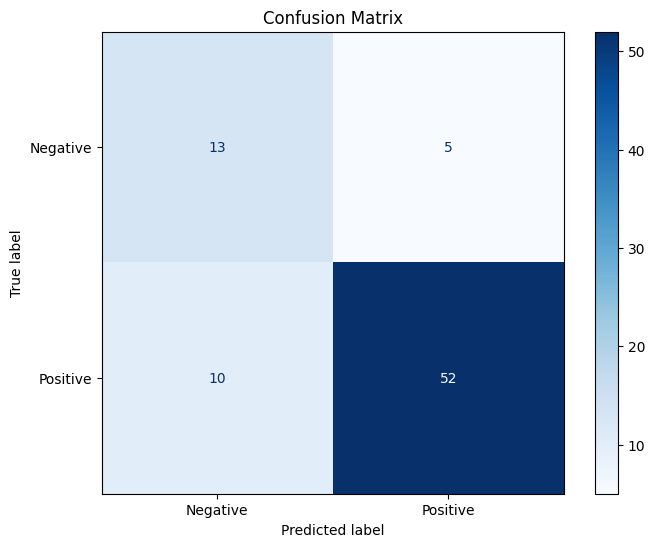


Testing Examples:
Review: "This product is excellent! I love it."
Prediction: 1 (0=negative, 1=positive)

Review: "I hate this product. It's terrible."
Prediction: 0 (0=negative, 1=positive)

Review: "Not what I expected, but it's okay."
Prediction: 0 (0=negative, 1=positive)

Review: "Fantastic quality! Highly recommend."
Prediction: 1 (0=negative, 1=positive)

Review: "Worst purchase I've ever made."
Prediction: 0 (0=negative, 1=positive)



In [ ]:
# Import the modules that are used in.
import pandas as pd
import re
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Suppress FutureWarning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Headling : Used Pretrained model and tokenizer tool
# Load pre-trained model and tokenizer
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Import our datat using pandas module (tool)
dataset = pd.read_csv('Reviews.csv')

# Dropping duplicates Records or reviews from dataset
dataset = dataset.drop_duplicates(subset={"UserId", "ProfileName", "Time", "Text"}, keep='first', inplace=False)


# Select first four 400 reviews
dataset = dataset.sample(n=400, random_state=42)

# Heading : Text cleaning functions
# Remove the Htlm text from dataset , example: <html>
def removeHTMLTags(review):
    return re.sub(r'<.*?>', '', review)

#Remove Apostrophe from reviews examples:  ' '' " "
def removeApostrophe(review):
    phrase = re.sub(r"won't", "will not", review)
    phrase = re.sub(r"can\'t", "can not", review)
    phrase = re.sub(r"n\'t", " not", review)
    phrase = re.sub(r"\'re", " are", review)
    phrase = re.sub(r"\'s", " is", review)
    phrase = re.sub(r"\'d", " would", review)
    phrase = re.sub(r"\'ll", " will", review)
    phrase = re.sub(r"\'t", " not", review)
    phrase = re.sub(r"\'ve", " have", review)
    phrase = re.sub(r"\'m", " am", review)
    return phrase
# remove the Alpha Numeric words
def removeAlphaNumericWords(review):
    return re.sub("\S*\d\S*", "", review).strip()
#remove special characters from reviews, example : % # @
def removeSpecialChars(review):
    return re.sub('[^a-zA-Z]', ' ', review)
# Cleaning Text to call All functions
def doTextCleaning(review):
    review = removeHTMLTags(review)
    review = removeApostrophe(review)
    review = removeAlphaNumericWords(review)
    review = removeSpecialChars(review)
    review = review.lower()
    return review

# Mapping the Score to binary (1,0) sentiment label, if score is equal and greater than 4, map to 1 and otherwise 0
def score_to_label(score):
    return 1 if score >= 4 else 0

# Creating the document corpus list and binary labels list
corpus = []
labels = []
for index, row in tqdm(dataset.iterrows(), total=dataset.shape[0]):
    review = doTextCleaning(row['Text'])
    corpus.append(review)
    labels.append(score_to_label(row['Score']))

# Count the total reviews and also count the positive nd negative reviews and print on screen
total_reviews = len(labels)
positive_reviews = sum(labels)
negative_reviews = total_reviews - positive_reviews

print(f"Total Reviews: {total_reviews}")
print(f"Positive Reviews: {positive_reviews}")
print(f"Negative Reviews: {negative_reviews}")

# Split the dataset into training and validation sets, 80% datsset is used for training and 20% for testing
train_texts, val_texts, train_labels, val_labels = train_test_split(corpus, labels, test_size=0.2, random_state=42)

# Custom Dataset class is class is used to manage and prepare your text data and corresponding labels for input into a model
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Hyperparameters are used for training,
batch_size = 4
epochs = 3
learning_rate = 3e-5
max_length = 512

# DataLoader for batching data
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}')

# Save the fine-tuned model to current directory
model.save_pretrained('fine_tuned_model')
tokenizer.save_pretrained('fine_tuned_model')

# Function to predict sentiment, to predict the sentement on review
def predict_sentiment(review):
    inputs = tokenizer(review, return_tensors='pt', truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    return prediction

# Test the prediction function: take input from user in form of sentence and function return the pridiction in binary value (1,0)
sample_text = "I love this product! It's amazing."
prediction = predict_sentiment(sample_text)
print(f"Sentiment: {'Positive' if prediction == 1 else 'Negative'}")


from sklearn.metrics import classification_report

# To Evaluate the model on validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Calculate positive as well as negative sentiment precision, recall, and f1 score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, labels=[0, 1])

# Print the result of Precision, Recall, and F1-Score
print(f'Precision for Negative Sentiment: {precision[0]:.4f}')
print(f'Recall for Negative Sentiment: {recall[0]:.4f}')
print(f'F1 Score for Negative Sentiment: {f1[0]:.4f}')

print(f'Precision for Positive Sentiment: {precision[1]:.4f}')
print(f'Recall for Positive Sentiment: {recall[1]:.4f}')
print(f'F1 Score for Positive Sentiment: {f1[1]:.4f}')

# We use the  classification report for more understanding
report = classification_report(all_labels, all_preds, target_names=['Negative', 'Positive'])
print("\nClassification Report:")
print(report)

# print Confusion Matrix  plot
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Negative', 'Positive'])


fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Now test the model
examples = [
    "This product is excellent! I love it.",
    "I hate this product. It's terrible.",
    "Not what I expected, but it's okay.",
    "Fantastic quality! Highly recommend.",
    "Worst purchase I've ever made."
]

print("\nTesting Examples:")
for example in examples:
    cleaned_example = doTextCleaning(example)
    prediction = predict_sentiment(cleaned_example)
    print(f'Review: "{example}"')
    print(f'Prediction: {prediction} (0=negative, 1=positive)\n')

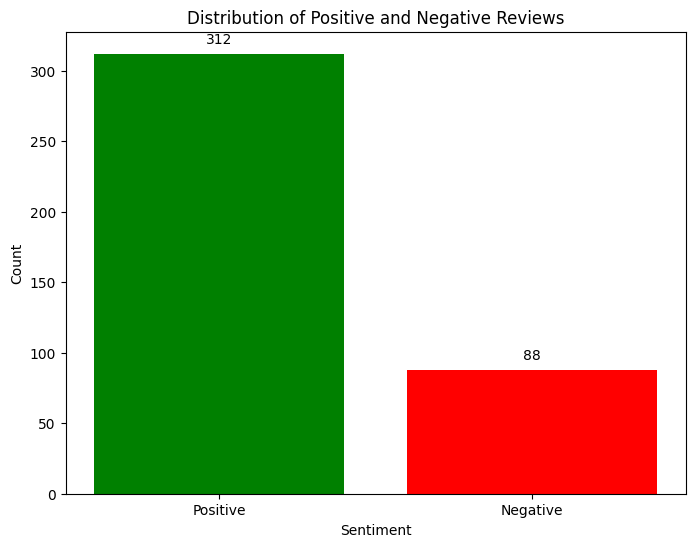

In [ ]:
# Now Print the plot bar chart for review sentiment distribution
def plot_sentiment_distribution(positive_count, negative_count):
    labels = ['Positive', 'Negative']
    counts = [positive_count, negative_count]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(labels, counts, color=['green', 'red'])
    ax.set_xlabel('Sentiment')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Positive and Negative Reviews')

    for i, count in enumerate(counts):
        ax.text(i, count + 5, str(count), ha='center', va='bottom')

    plt.show()

# to Call the function to show the plot sentiment distribution
plot_sentiment_distribution(positive_reviews, negative_reviews)


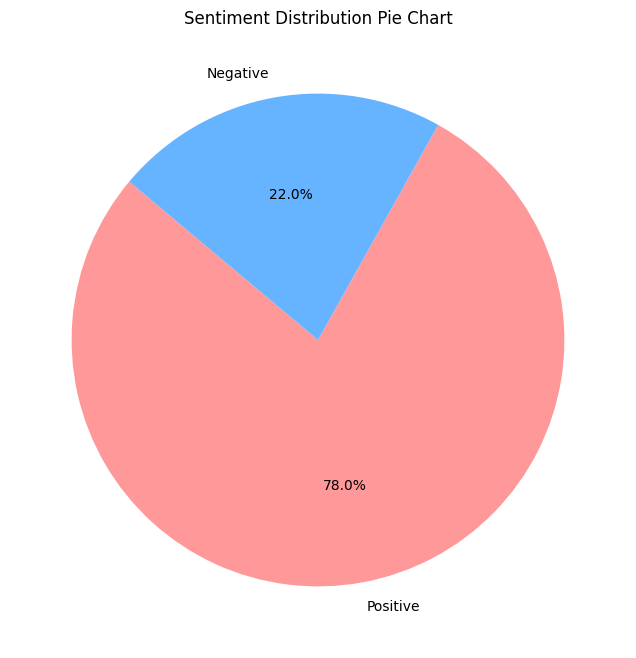

In [ ]:
# Show the plot for pie chart
def plot_sentiment_pie_chart(positive_count, negative_count):
    labels = ['Positive', 'Negative']
    sizes = [positive_count, negative_count]
    colors = ['#ff9999','#66b3ff']

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    ax.set_title('Sentiment Distribution Pie Chart')
    plt.show()

# Call the function to show the pie chart plot
plot_sentiment_pie_chart(positive_reviews, negative_reviews)


100%|██████████| 80/80 [41:57<00:00, 31.47s/it]


Epoch 1/3, Loss: 0.11081151338876224


100%|██████████| 80/80 [37:40<00:00, 28.26s/it]


Epoch 2/3, Loss: 0.007897194035467691


100%|██████████| 80/80 [37:40<00:00, 28.26s/it]


Epoch 3/3, Loss: 0.003078224859200418


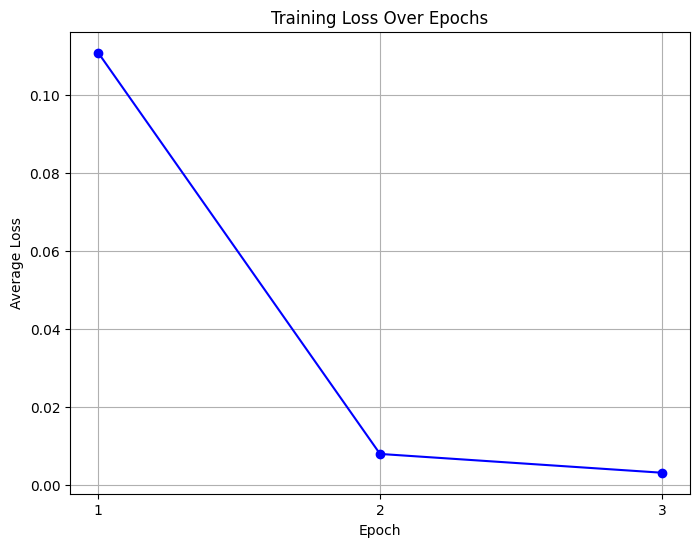

In [4]:
# Define a list to keep track of loss per epoch
epoch_losses = []

# Training loop (with loss tracking)
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}')

# Function to plot line chart of loss
def plot_loss_over_epochs(losses):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='b')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Loss')
    ax.set_title('Training Loss Over Epochs')
    plt.xticks(range(1, len(losses) + 1))
    plt.grid(True)
    plt.show()

# Call the function to plot loss over epochs
plot_loss_over_epochs(epoch_losses)


# New Section

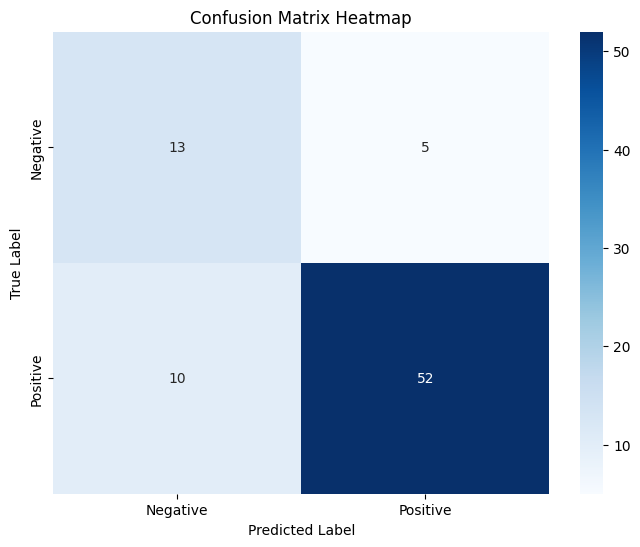

In [5]:
import seaborn as sns

# Function to plot confusion matrix heatmap
def plot_confusion_matrix_heatmap(conf_matrix):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix Heatmap')
    plt.show()

# Call the function to plot confusion matrix heatmap
plot_confusion_matrix_heatmap(conf_matrix)


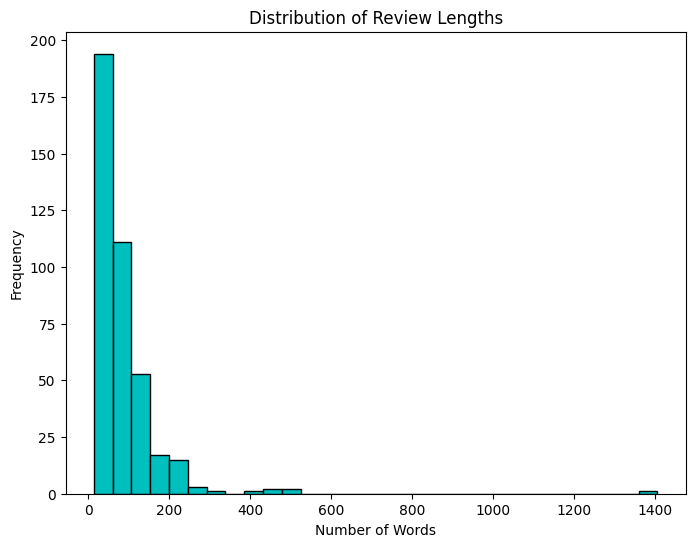

In [6]:
# Function to plot histogram of review lengths
def plot_review_length_distribution(reviews):
    lengths = [len(review.split()) for review in reviews]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hist(lengths, bins=30, color='c', edgecolor='black')
    ax.set_xlabel('Number of Words')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Review Lengths')
    plt.show()

# Call the function to plot review length distribution
plot_review_length_distribution(corpus)
